In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mask detection in images

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


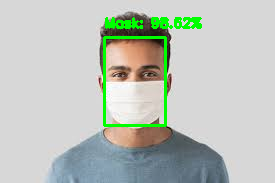

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

input_file_path = "/content/drive/MyDrive/computer visison/download (1).jpg"

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/MyDrive/computer visison/Face-Mask-Detection-master/Face-Mask-Detection-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/computer visison/Face-Mask-Detection-master/Face-Mask-Detection-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.model")

def process_images(input_file_path):
	# load the input image from disk, clone it, and grab the image spatial
  # dimensions
	image = cv2.imread(input_file_path)
	# orig = image.copy()
	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# pass the face through the model to determine if the face
			# has a mask or not
			(mask, withoutMask) = model.predict(face)[0]

			# determine the class label and color we'll use to draw
			# the bounding box and text
			label = "Mask" if mask > withoutMask else "No Mask"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

			# include the probability in the label
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

			# display the label and bounding box rectangle on the output
			# frame
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

	# show the output image
	save_path = input_file_path.split(".",1)
	# print (save_path[0])
	# print (save_path[-1])
	cv2_imshow(image)
	# cv2.imwrite(save_path[0] + "_pred." + save_path[-1],image)

#start the process
process_images(input_file_path)

##Video processing

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from imutils.video import FPS

from google.colab.patches import cv2_imshow
import pdb

#Input video file path
input_video_path = "/content/drive/MyDrive/computer visison/200323 - Coronavirus_01_4k_011.mp4"

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		preds = maskNet.predict(faces)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/MyDrive/computer visison/Face-Mask-Detection-master/Face-Mask-Detection-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/computer visison/Face-Mask-Detection-master/Face-Mask-Detection-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model("mask_detector.model")

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
file_path = input_video_path.split(".",1)
vs = cv2.VideoCapture(input_video_path)
length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
time.sleep(2.0)

#checking video available or not
grabbed, frame_flip = vs.read()
if not(grabbed): print ("INPUT VIDEO NOT FOUND!")

# loop over the frames from the video stream
count = 0
img_array = []
while grabbed:
	(grabbed, frame) = vs.read()
	if not(grabbed): break
	if (count==0): print ("[INFO] processing started...")
	frame = imutils.resize(frame, width=400)
  
	#Optional step (comment if not needed)
	frame = cv2.rotate(frame, cv2.ROTATE_180)
	
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
	
	# cv2_imshow(frame)
	height, width, layers = frame.shape
	size = (width,height)
	img_array.append(frame)
	print ("\r[INFO] Count: {}/{}".format(count, length),end='')
	count+=1

#Saving all output frames as MP4 video
print ("\n[INFO] Saving video")
video = cv2.VideoWriter(file_path[0] + "_OUTPUT." + file_path[-1], cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    video.write(img_array[i])
video.release()
print ("[INFO] process complete.")

# vs.stop()

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...
[INFO] processing started...
[INFO] Count: 195/197
[INFO] Saving video
[INFO] process complete.
